#Todos os import's necessários para o funcionamento do código

In [6]:
from matplotlib import style
from IPython.display import display
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from scipy import sparse, stats
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.linear_model import LogisticRegressionCV
from xgboost import XGBClassifier

C:\Python39\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


#Itens importantes para a Análise dos Dados, fazendo o carregamento de dados

In [7]:
df_treino = pd.read_csv('C:/Users/Samsung/Downloads/train.csv/train.csv')
df_teste = pd.read_csv('C:/Users/Samsung/Downloads/test.csv/test.csv')
submissao = pd.read_csv('C:/Users/Samsung/Downloads/sample_submission.csv/sample_submission.csv')

treino = df_treino.copy()
teste = df_teste.copy()

#Removendo target dos dados
labels = treino.pop('target')
y = labels.values

#Remover e salvar o id de cada base da dado
treino_id = treino.pop('id')
teste_id = teste.pop('id')

#Exploração de Análise da Dados

In [8]:
def VisaoGeral(df):
    '''funciona como o describe, mas é ampliado para melhor visualização dos dados'''

    print(f"Forma do Dataset: {df.shape}")
    sumario = pd.DataFrame(df.dtypes,columns=['dtypes'])
    sumario = sumario.reset_index()
    sumario['Name'] = sumario['index']
    sumario = sumario[['Name','dtypes']]
    sumario['Missing'] = df.isnull().sum().values
    sumario['Uniques'] = df.nunique().values

    for nome in sumario['Name'].value_counts().index:
        sumario.loc[sumario['Name'] == nome, 'Entropy'] = round(stats.entropy(df[nome].value_counts(normalize=True), base=2),2)
    return sumario
sumario = VisaoGeral(treino)
display(sumario.head())

#Descrever a informação obtida para melhor entendimento
def Descrever_informacao(tno, tst):
    """Descrever a diferenca entre cada datasets"""

    status = []
    Analise = list(treino.columns)

    for coluna in Analise:
        dtreino = dict(treino[coluna].value_counts())
        dteste = dict(teste[coluna].value_counts())

        teste_nao_treino = set(dteste.keys()) - set(dtreino.keys())
        treino_nao_teste = set(dtreino.keys()) - set(dteste.keys())

        dict_treino_nao_teste = {key:value for key, value in dtreino.items() if key in treino_nao_teste}
        dict_teste_nao_treino = {key:value for key, value in dteste.items() if key in teste_nao_treino}

        items_teste, tot_teste = len(dteste), pd.Series(dteste).sum()
        items_treino_nao_teste, tot_treino_nao_teste = len(dict_treino_nao_teste), pd.Series(dict_treino_nao_teste, dtype='float32').sum()
        items_treino, tot_treino = len(dtreino), pd.Series(dtreino).sum()
        items_teste_nao_treino, tot_teste_nao_treino = len(dict_teste_nao_treino), pd.Series(dict_teste_nao_treino, dtype='float32').sum()

        status.append((
            str(coluna),
            str(items_treino_nao_teste) + ' (' + str(round(100* items_treino_nao_teste/ items_treino,1)) + '%)',
            str(items_teste_nao_treino) + ' (' + str(round(100* items_teste_nao_treino/ items_teste,1)) + '%)'
        ))

    df_status = pd.DataFrame(status, columns=[
        "Variáveis",
        "Valores únicos no treino e não no teste (%)",
        "Valores únicos no teste e não no treino (%)"])
    return df_status
Descrever_informacao(treino, teste)


Forma do Dataset: (600000, 23)


,Name,dtypes,Missing,Uniques,Entropy
0,bin_0,float64,17894,2,0.44
1,bin_1,float64,18003,2,0.69
2,bin_2,float64,17930,2,0.85
3,bin_3,object,18014,2,0.95
4,bin_4,object,18047,2,1.00


,Variáveis,Valores únicos no treino e não no teste (%),Valores únicos no teste e não no treino (%)
0,bin_0,0 (0.0%),0 (0.0%)
1,bin_1,0 (0.0%),0 (0.0%)
2,bin_2,0 (0.0%),0 (0.0%)
3,bin_3,0 (0.0%),0 (0.0%)
4,bin_4,0 (0.0%),0 (0.0%)
5,nom_0,0 (0.0%),0 (0.0%)
6,nom_1,0 (0.0%),0 (0.0%)
7,nom_2,0 (0.0%),0 (0.0%)
8,nom_3,0 (0.0%),0 (0.0%)
9,nom_4,0 (0.0%),0 (0.0%)


#Criação dos Gráficos

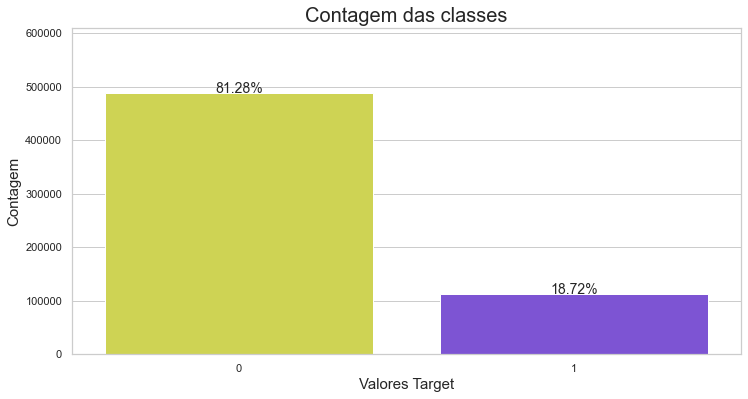

In [9]:
#Cores dos gráficos
colores = ["#e2e83f", "#753fe8", "#f1c40fff", "#8a327f", "#4d669e","#2ecc4e"]
colores = sns.color_palette(colores)

#Criando gráfico inicial dos objetivos
total = len(df_treino)

plt.figure(figsize=(12,6))

sns.set(style="whitegrid")
g = sns.countplot(x='target', data = df_treino, palette = colores)
g.set_title("Contagem das classes", fontsize = 20)
g.set_xlabel("Valores Target", fontsize = 15)
g.set_ylabel("Contagem", fontsize = 15)
sizes=[]
# código para as porcentagens em cada barra
for pc in g.patches:
    height = pc.get_height()
    sizes.append(height)
    g.text(pc.get_x()+pc.get_width()/2.,
            height + 6,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=14)
g.set_ylim(0, max(sizes) * 1.25)

plt.show()

#Análise de Variáveis Binárias

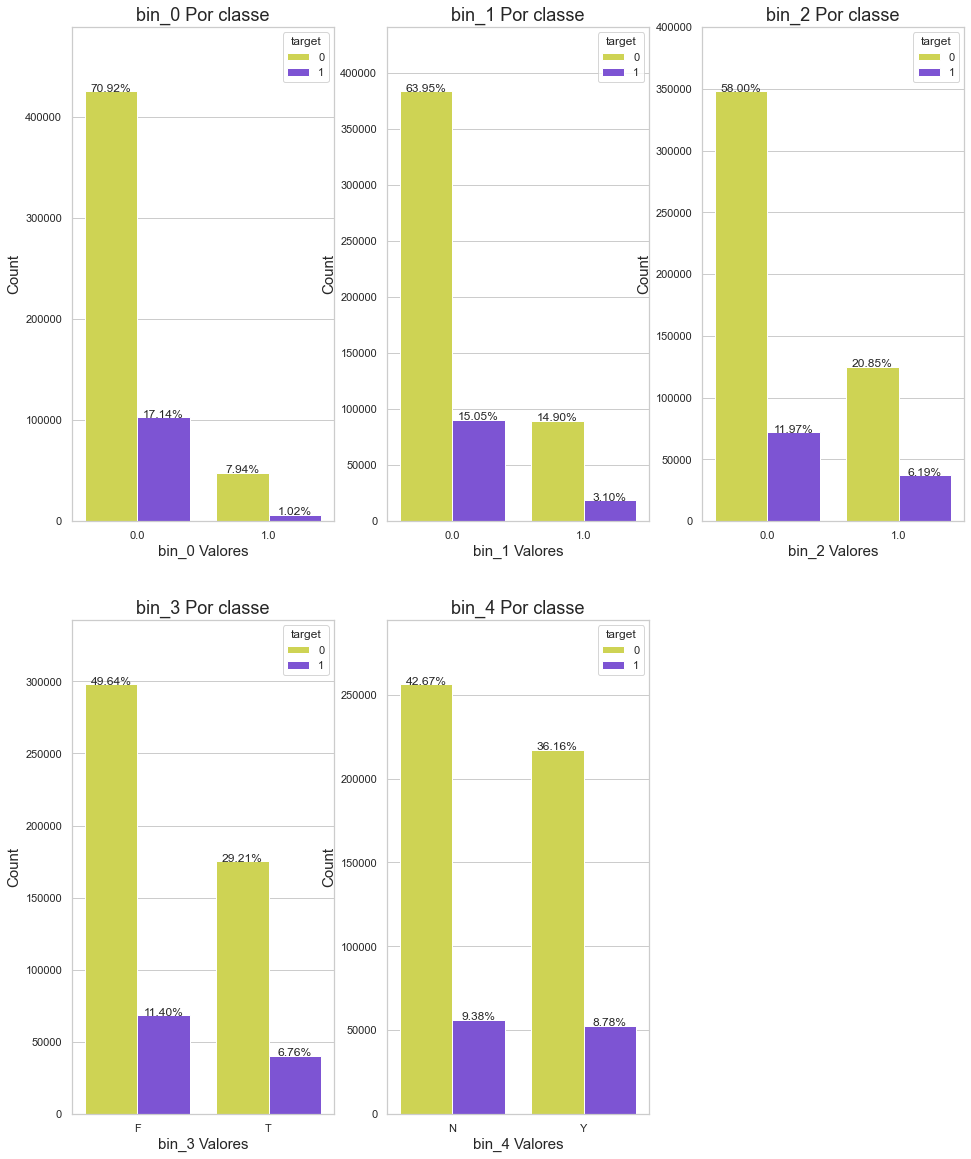

In [10]:
#Vamos fazer um rede de dados, sabendo que tendo 5 variáveis binárias
#Iremos plotar em 2 linhas e 3 colunas.

rede = gridspec.GridSpec(2, 3)
plt.figure(figsize=(16,20))

#Teremos um contador de Plots em casa var. binária
#Por essa razão utilizamos um loop
coluna_bin = ['bin_0', 'bin_1', 'bin_2', 'bin_3', 'bin_4']
for b, coluna in enumerate(df_treino[coluna_bin]):
    ax = plt.subplot(rede[b])
    sns.countplot(x=coluna, data=df_treino, hue='target', palette=colores)
    ax.set_ylabel('Count', fontsize=15)
    ax.set_title(f'{coluna} Por classe', fontsize=18)
    ax.set_xlabel(f'{coluna} Valores', fontsize=15)
    sizes=[]
    #Porcentagem em barra novamente
    for p in ax.patches:
        height = p.get_height()
        sizes.append(height)
        ax.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(height/total*100),
                ha="center", fontsize=12)
    ax.set_ylim(0, max(sizes) * 1.15)

plt.show()


#Análise de Variáveis Nominais


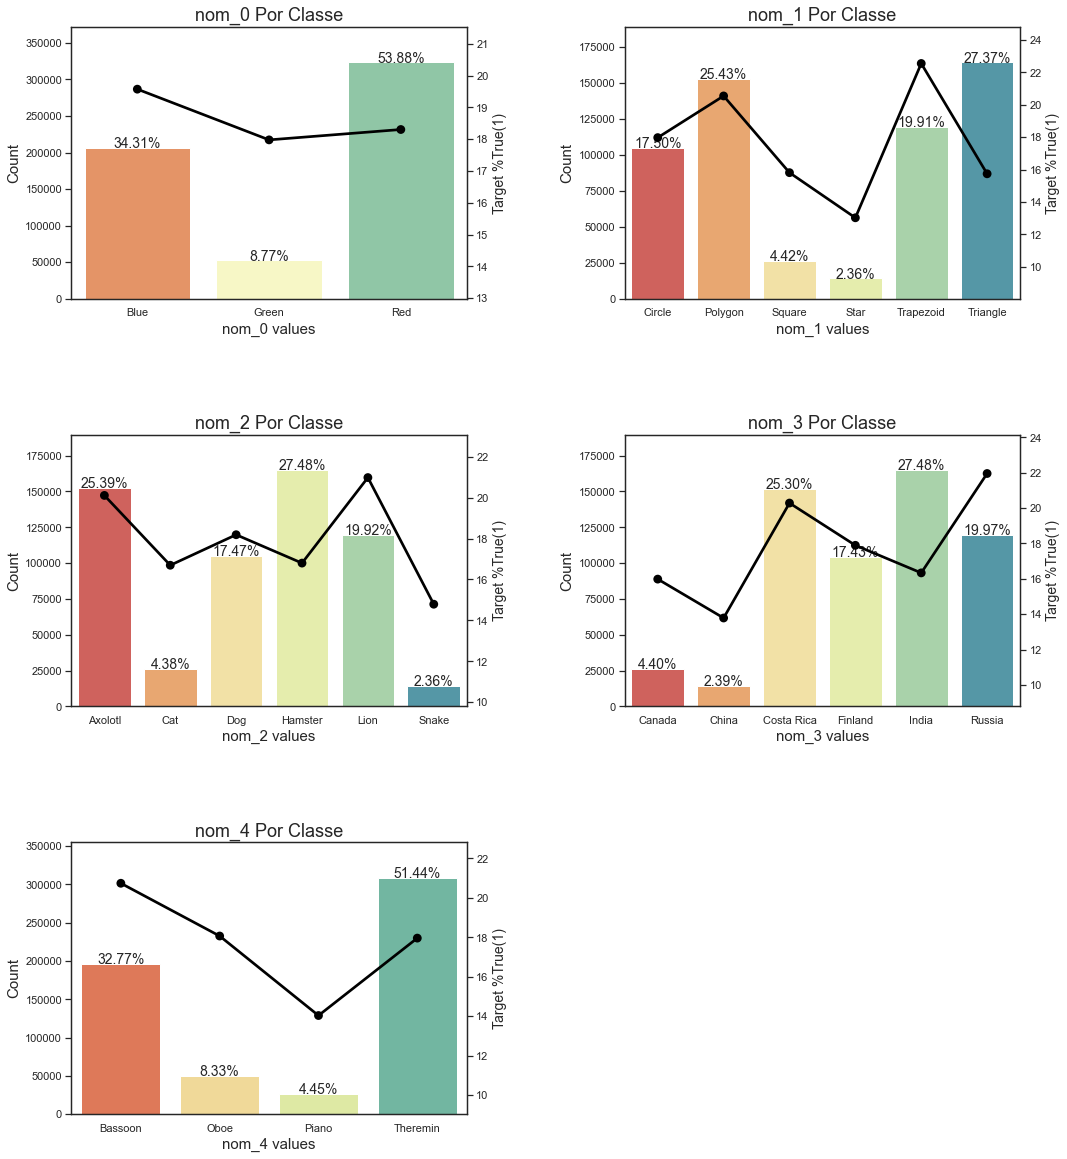

In [11]:
#Todas as colunas nominais = ['nom_0', 'nom_1', 'nom_2', 'nom_3', 'nom_4', 'nom_5', 'nom_6', 'nom_7', 'nom_8', 'nom_9']
#Porém só trabalharemos com as que estão abaixo
coluna_nom = ['nom_0', 'nom_1', 'nom_2', 'nom_3', 'nom_4']


def Plotar_cat(df, cols, vis_row=5, vis_col=2):
    sns.set(style="white")

    grid = gridspec.GridSpec(vis_row,vis_col)
    plt.figure(figsize=(17, 35)) #tamanho 

    #Loop para calcular o n de colunas e contar as plotagens
    for n, col in enumerate(df_treino[cols]):
        tmp = pd.crosstab(df_treino[col], df_treino['target'], normalize='index') * 100
        tmp = tmp.reset_index()
        tmp.rename(columns={0:'No',1:'Yes'}, inplace=True)

        ax = plt.subplot(grid[n]) #Preenchendo a rede
        sns.countplot(x=col, data=df_treino, order=list(tmp[col].values), palette='Spectral')
        ax.set_ylabel('Count', fontsize=15) #Eixo Y
        ax.set_title(f'{col} Por Classe', fontsize=18) #Título
        ax.set_xlabel(f'{col} values', fontsize=15) #Eixo X

        # twinX - construir um segundo eixo para Y
        gt = ax.twinx()
        gt = sns.pointplot(x=col, y='Yes', data=tmp,
                           order=list(tmp[col].values),
                           color='black', legend=False)
        gt.set_ylim(tmp['Yes'].min()-5,tmp['Yes'].max()*1.1)
        gt.set_ylabel("Target %True(1)", fontsize=14)
        sizes=[] #Capturar os maiores valores de Y
        for p in ax.patches: #Botar todos os objetos em loop
            height = p.get_height()
            sizes.append(height)
            ax.text(p.get_x()+p.get_width()/2.,
                    height + 3,
                    '{:1.2f}%'.format(height/total*100),
                    ha="center", fontsize=14)
        ax.set_ylim(0, max(sizes) * 1.15) #Montar os limites de y baseado nos maiores valores encontrados


    plt.subplots_adjust(hspace = 0.5, wspace=.4)
    plt.show()

Plotar_cat(df_treino, coluna_nom, vis_row=5, vis_col=2)

#Análise da Variáveis Ordenadas

#E corrigir dados da ord_1 e ord_2 para entender seus funcionamentos


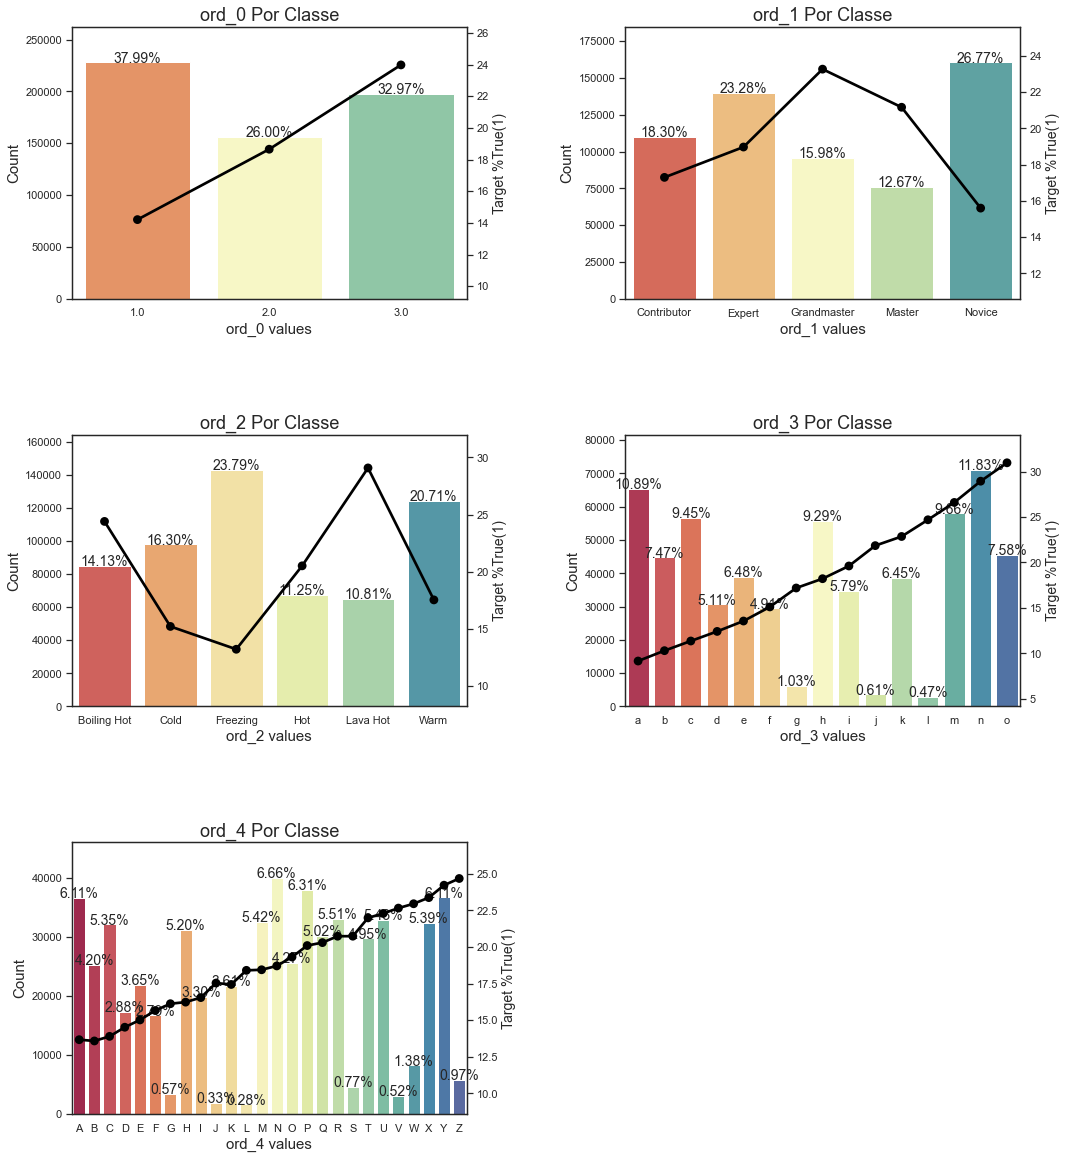

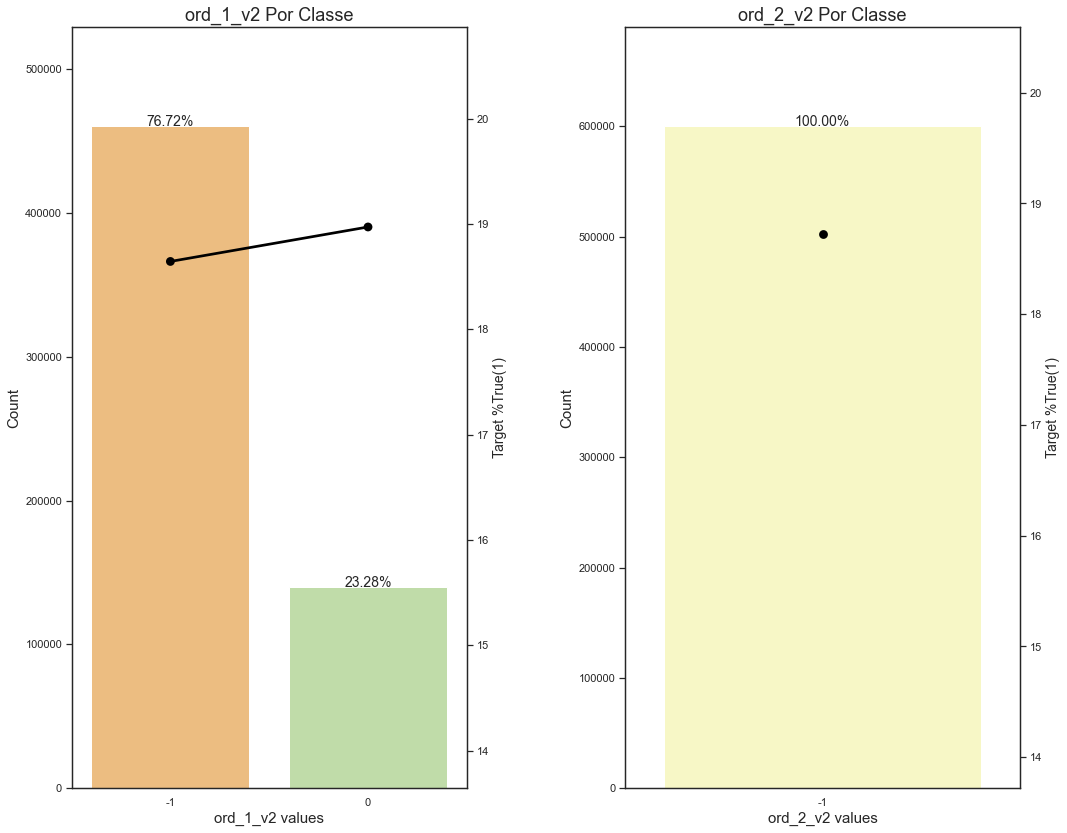

In [12]:
coluna_ord = ['ord_0', 'ord_1', 'ord_2', 'ord_3', 'ord_4']
Plotar_cat(df_treino, coluna_ord, vis_row=5, vis_col=2)

# Vamos criar funções para conversão
def ord_para_fac(df, name, categories):
    ''' Conversao para uma ordem de fatores. '''
    raw_cat = pd.Categorical(df[name], categories=categories, ordered=True)
    labels, unique = pd.factorize(raw_cat, sort=True)
    nova_ide = name + '_v2'
    df[nova_ide] = labels

def ord_para_num(name, df, categories):
    ''' Conversao para ordem numérica ou alfabética. '''
    raw_cat = pd.Categorical(df[name], categories=categories, ordered=True)
    encoder = LabelEncoder()
    encoded = encoder.fit_transform(raw_cat)
    nova_ide = name + '_v2'
    df[nova_ide] = encoded


# Verificando as classes nas variáveis ordinais
unique_ord0 = df_treino['ord_0'].unique()
unique_ord1 = df_treino['ord_1'].unique()
unique_ord2 = df_treino['ord_2'].unique()
unique_ord3 = df_treino['ord_3'].unique()
unique_ord4 = df_treino['ord_4'].unique()
unique_ord5 = df_treino['ord_5'].unique()

nome = 'ord_1'
categorias = ['Recruta', 'Soldado', 'Expert', 'Grao-Mestre', 'Mestre']
ord_para_fac(df_treino, nome, categorias)

df_treino.columns


nome = 'ord_2'
categorias = ['Congelando', 'Frio', 'Calor', 'Quente', 'Fervendo', 'Muito quente']
ord_para_fac(df_treino, nome, categorias)

coluna_ord = ['ord_1_v2', 'ord_2_v2']
Plotar_cat(df_treino, coluna_ord, vis_row=2, vis_col=2)

#Caso excepcional da ord_5


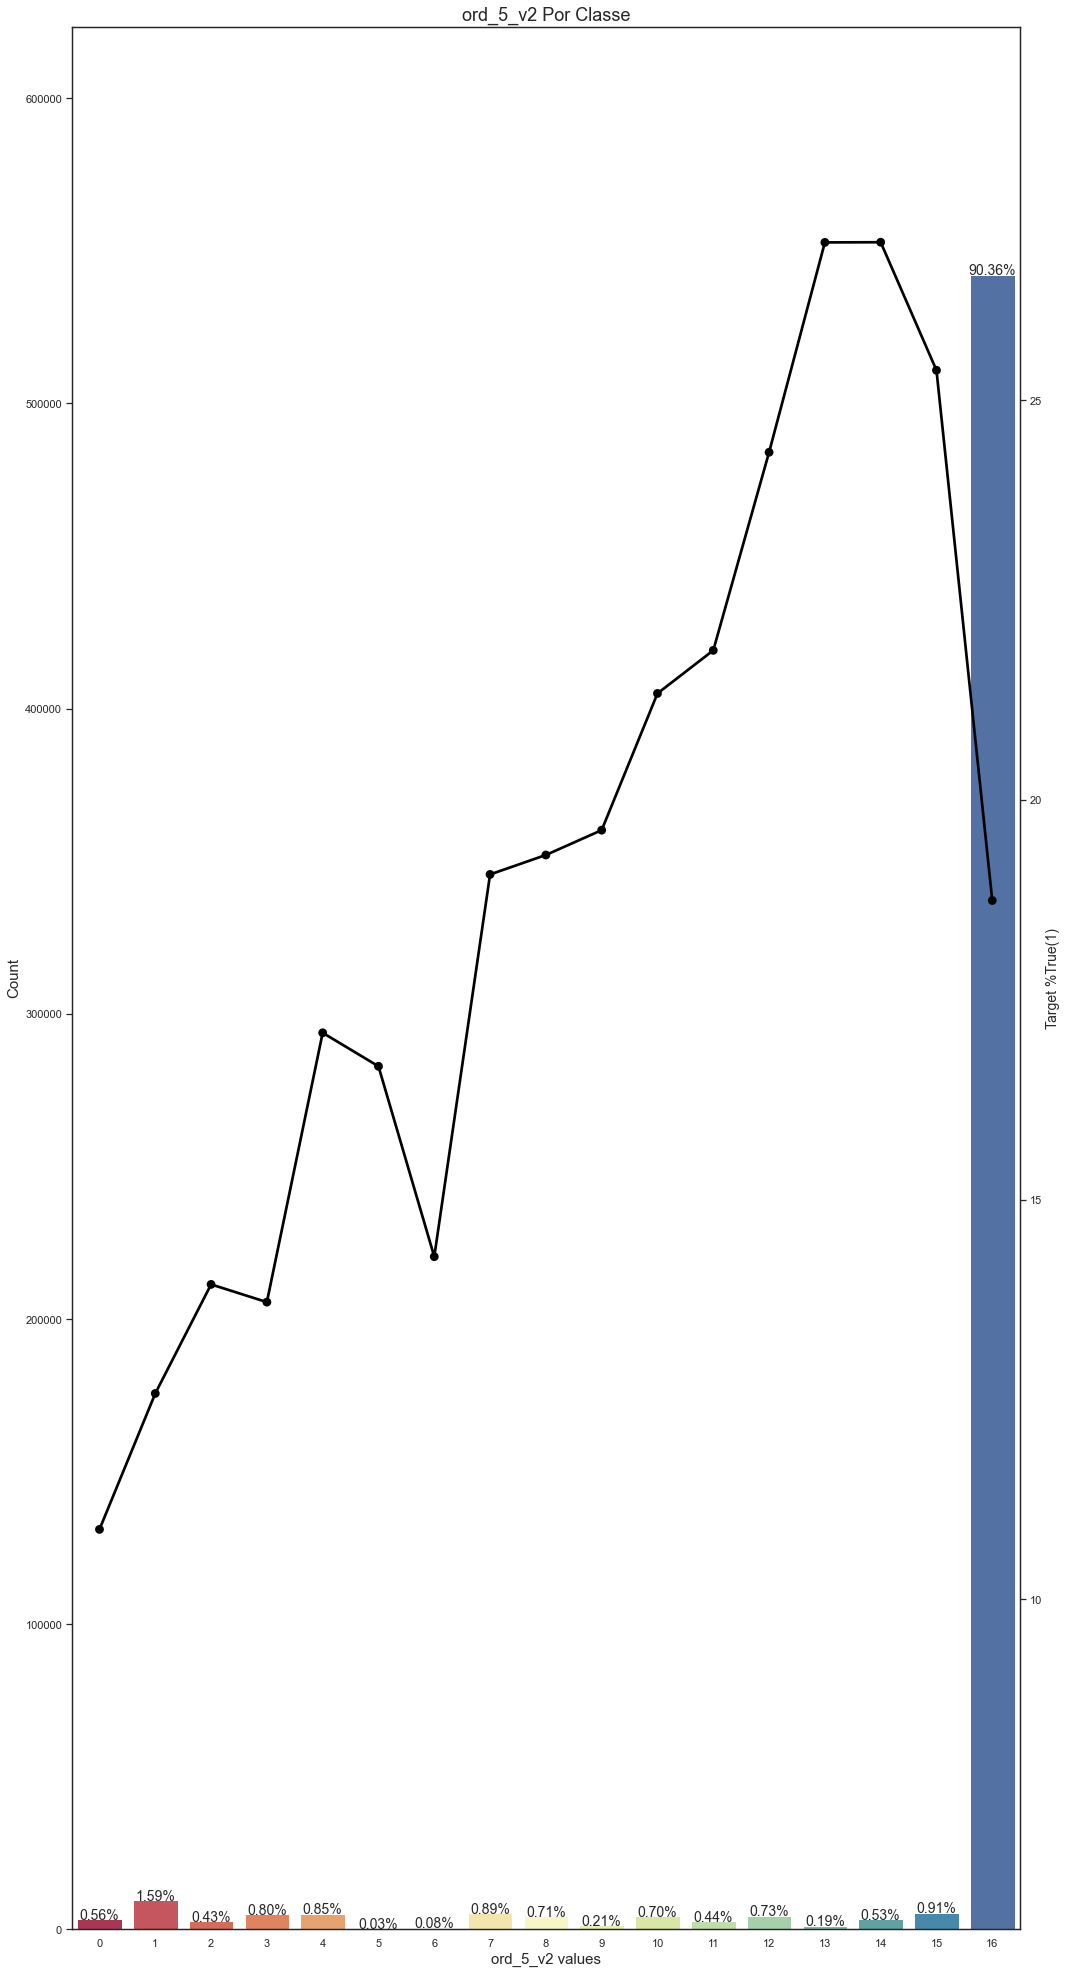

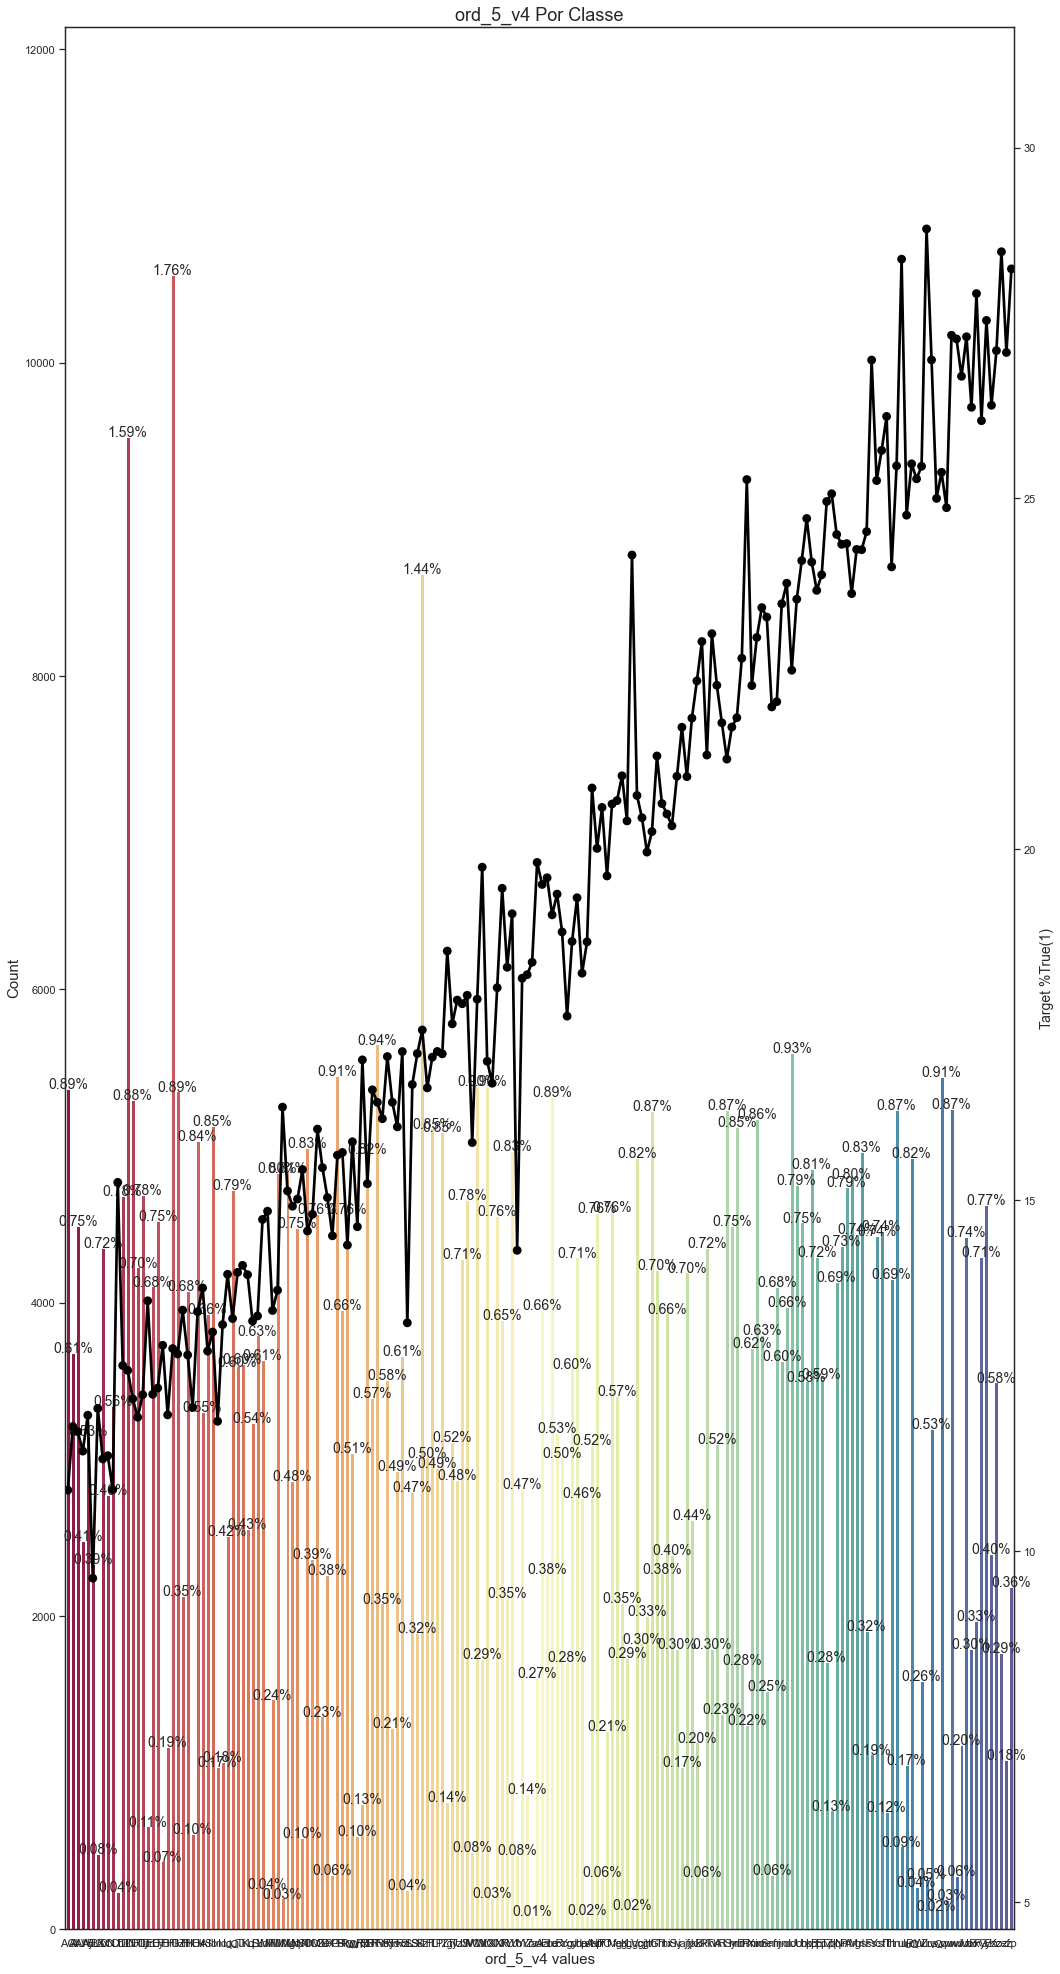

In [13]:
nome = 'ord_5'
categorias = ['AP', 'Ai', 'Aj', 'BA', 'BE', 'Bb', 'Bd', 'Bn', 'CL', 'CM', 'CU',
       'CZ', 'Cl', 'DH', 'DN', 'Dc', 'Dx', 'Ed', 'Eg', 'Er', 'FI', 'Fd',
       'Fo', 'GD', 'GJ', 'Gb', 'Gx', 'Hj', 'IK', 'Id', 'JX', 'Jc', 'Jf',
       'Jt', 'KR', 'KZ', 'Kf', 'Kq', 'LE', 'MC', 'MO', 'MV', 'Mf', 'Ml',
       'Mx', 'NV', 'Nf', 'Nk', 'OR', 'Ob', 'Os', 'PA', 'PQ', 'PZ', 'Ps',
       'QM', 'Qb', 'Qh', 'Qo', 'RG', 'RL', 'RP', 'Rm', 'Ry', 'SB', 'Sc',
       'TR', 'TZ', 'To', 'UO', 'Uk', 'Uu', 'Vf', 'Vx', 'WE', 'Wc', 'Wv',
       'XI', 'Xh', 'Xi', 'YC', 'Yb', 'Ye', 'ZR', 'ZS', 'Zc', 'Zq', 'aF',
       'aM', 'aO', 'aP', 'ac', 'av', 'bF', 'bJ', 'be', 'cA', 'cG', 'cW',
       'ck', 'cp', 'dB', 'dE', 'dN', 'dO', 'dP', 'dQ', 'dZ', 'dh', 'eG',
       'eQ', 'eb', 'eg', 'ek', 'ex', 'fO', 'fh', 'gJ', 'gM', 'hL', 'hT',
       'hh', 'hp', 'iT', 'ih', 'jS', 'jV', 'je', 'jp', 'kC', 'kE', 'kK',
       'kL', 'kU', 'kW', 'ke', 'kr', 'kw', 'lF', 'lL', 'll', 'lx', 'mb',
       'mc', 'mm', 'nX', 'nh', 'oC', 'oG', 'oH', 'oK', 'od', 'on', 'pa',
       'ps', 'qA', 'qJ', 'qK', 'qP', 'qX', 'qo', 'qv', 'qw', 'rZ', 'ri',
       'rp', 'sD', 'sV', 'sY', 'sn', 'su', 'tM', 'tP', 'tv', 'uJ', 'uS',
       'ud', 'us', 'ut', 'ux', 'uy', 'vK', 'vq', 'vy', 'wu', 'wy', 'xP',
       'xy', 'yN', 'yY', 'yc', 'zU']
ord_para_num(nome, df_treino, categorias)


coluna_ord = ['ord_5_v2']
Plotar_cat(df_treino, coluna_ord, vis_row=1, vis_col=1)

#Considerando que a variável ord_5 é o resultado da junção de 2 outras
#sendo um caractere de uma variável e o outro de outra.
categorias = ['AP', 'Ai', 'Aj', 'BA', 'BE', 'Bb', 'Bd', 'Bn', 'CL', 'CM', 'CU',
       'CZ', 'Cl', 'DH', 'DN', 'Dc', 'Dx', 'Ed', 'Eg', 'Er', 'FI', 'Fd',
       'Fo', 'GD', 'GJ', 'Gb', 'Gx', 'Hj', 'IK', 'Id', 'JX', 'Jc', 'Jf',
       'Jt', 'KR', 'KZ', 'Kf', 'Kq', 'LE', 'MC', 'MO', 'MV', 'Mf', 'Ml',
       'Mx', 'NV', 'Nf', 'Nk', 'OR', 'Ob', 'Os', 'PA', 'PQ', 'PZ', 'Ps',
       'QM', 'Qb', 'Qh', 'Qo', 'RG', 'RL', 'RP', 'Rm', 'Ry', 'SB', 'Sc',
       'TR', 'TZ', 'To', 'UO', 'Uk', 'Uu', 'Vf', 'Vx', 'WE', 'Wc', 'Wv',
       'XI', 'Xh', 'Xi', 'YC', 'Yb', 'Ye', 'ZR', 'ZS', 'Zc', 'Zq', 'aF',
       'aM', 'aO', 'aP', 'ac', 'av', 'bF', 'bJ', 'be', 'cA', 'cG', 'cW',
       'ck', 'cp', 'dB', 'dE', 'dN', 'dO', 'dP', 'dQ', 'dZ', 'dh', 'eG',
       'eQ', 'eb', 'eg', 'ek', 'ex', 'fO', 'fh', 'gJ', 'gM', 'hL', 'hT',
       'hh', 'hp', 'iT', 'ih', 'jS', 'jV', 'je', 'jp', 'kC', 'kE', 'kK',
       'kL', 'kU', 'kW', 'ke', 'kr', 'kw', 'lF', 'lL', 'll', 'lx', 'mb',
       'mc', 'mm', 'nX', 'nh', 'oC', 'oG', 'oH', 'oK', 'od', 'on', 'pa',
       'ps', 'qA', 'qJ', 'qK', 'qP', 'qX', 'qo', 'qv', 'qw', 'rZ', 'ri',
       'rp', 'sD', 'sV', 'sY', 'sn', 'su', 'tM', 'tP', 'tv', 'uJ', 'uS',
       'ud', 'us', 'ut', 'ux', 'uy', 'vK', 'vq', 'vy', 'wu', 'wy', 'xP',
       'xy', 'yN', 'yY', 'yc', 'zU']


ord_5_v3 = []
ord_5_v4 = []

for f in df_treino.ord_5.iteritems():
    lista = list(f)
    ord_5_v3.append(f[0])
    ord_5_v4.append(f[1])

df_treino['ord_5_v3'] = ord_5_v3
df_treino['ord_5_v4'] = ord_5_v4

df_treino.columns

coluna_ord = ['ord_5_v4']
Plotar_cat(df_treino, coluna_ord, vis_row=1, vis_col=1)

#Análise da Dados Cíclicos

#Dia

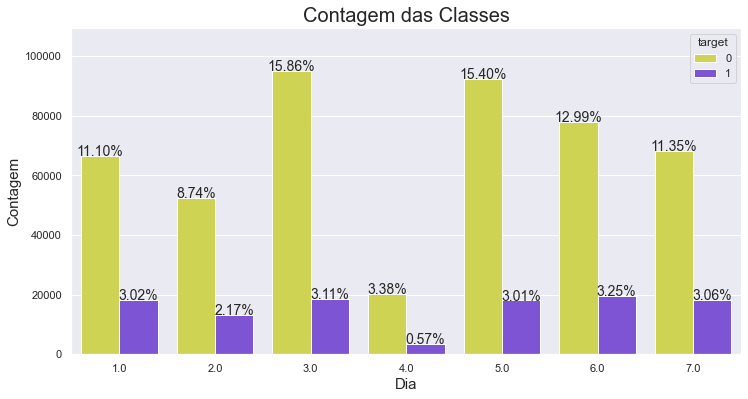

In [14]:
total = len(df_treino)

plt.figure(figsize=(12,6))

sns.set(style="darkgrid")
g = sns.countplot(x='day', hue='target', data=df_treino, palette=colores)
g.set_title("Contagem das Classes", fontsize = 20)
g.set_xlabel("Dia", fontsize = 15)
g.set_ylabel("Contagem", fontsize = 15)
sizes=[]
for p in g.patches:
    height = p.get_height()
    sizes.append(height)
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=14)
g.set_ylim(0, max(sizes) * 1.15)
plt.show()

#Mês

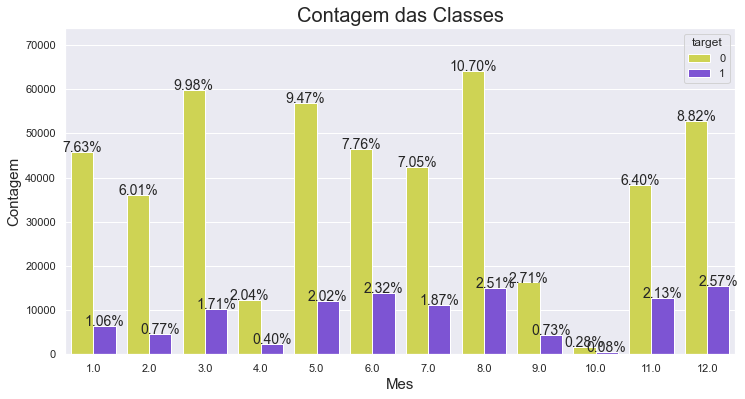

In [15]:
total = len(df_treino)

plt.figure(figsize=(12,6))

sns.set(style="darkgrid")
g = sns.countplot(x='month', hue='target', data=df_treino, palette=colores)
g.set_title("Contagem das Classes", fontsize = 20)
g.set_xlabel("Mes", fontsize = 15)
g.set_ylabel("Contagem", fontsize = 15)
sizes=[]
# código para porcentagens em cada barra
for p in g.patches:
    height = p.get_height()
    sizes.append(height)
    g.text(p.get_x()+p.get_width()/2.,
            height + 6,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=14)
g.set_ylim(0, max(sizes) * 1.15)

plt.show()

#Trabalharemos com os dois dataset juntos, até a etapa do aprendizado de máquina

In [16]:
df = pd.concat([treino, teste], axis=0)

#Precisamos converter alguns dados para que a análise tenha maior confiabilidade

#Verificando as classes nas variáveis ordinais e transformado-as


In [17]:
unique_ord0 = df['ord_0'].unique()
unique_ord1 = df['ord_1'].unique()
unique_ord2 = df['ord_2'].unique()
unique_ord3 = df['ord_3'].unique()
unique_ord4 = df['ord_4'].unique()
unique_ord5 = df['ord_5'].unique()


#Transformações
nome = 'ord_1'
categorias = ['Novice', 'Contributor', 'Expert', 'Master', 'Grandmaster']
ord_para_fac(df, nome, categorias)

nome = 'ord_2'
categorias = ['Frezing', 'Cold', 'Warm', 'Hot', 'Boiling Hot', 'Lava Hot']
ord_para_fac(df, nome, categorias)

nome = 'ord_3'
categorias = ['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o']
ord_para_num(nome, df, categorias)

nome = 'ord_4'
categorias = ['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z']
ord_para_num(nome, df, categorias)

ord_5_v3 = []
ord_5_v4 = []

for i in df.ord_5.iteritems():
    lista = list(i)
    ord_5_v3.append(i[0])
    ord_5_v4.append(i[1])

df['ord_5_v3'] = ord_5_v3


nome = 'ord_5_v3'
categorias = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
ord_para_num(nome, df, categorias)

df.columns

Index(['bin_0', 'bin_1', 'bin_2', 'bin_3', 'bin_4', 'nom_0', 'nom_1', 'nom_2',
       'nom_3', 'nom_4', 'nom_5', 'nom_6', 'nom_7', 'nom_8', 'nom_9', 'ord_0',
       'ord_1', 'ord_2', 'ord_3', 'ord_4', 'ord_5', 'day', 'month', 'ord_1_v2',
       'ord_2_v2', 'ord_3_v2', 'ord_4_v2', 'ord_5_v3', 'ord_5_v3_v2'],
      dtype='object')

#Verificando as classes nas variáveis binárias e transformado-as

#Além de tratar das variáveis cíclicas

In [18]:
unique_bin3 = df['bin_3'].unique()
unique_bin4 = df['bin_4'].unique()

nome = 'bin_3'
categorias = ['T', 'F']
ord_para_num(nome, df, categorias)

nome = 'bin_4'
categorias = ['Y', 'N']
ord_para_num(nome, df, categorias)

#Tratamento da Variáveis Cíclicas
df['quarters'] = pd.to_datetime(df['month'].values, format='%m').astype('period[Q]')
df_mes = pd.get_dummies(df['quarters'], prefix='v2', drop_first=False)
df = pd.concat([df, df_mes], axis=1)

df.columns

Index(['bin_0', 'bin_1', 'bin_2', 'bin_3', 'bin_4', 'nom_0', 'nom_1', 'nom_2',
       'nom_3', 'nom_4', 'nom_5', 'nom_6', 'nom_7', 'nom_8', 'nom_9', 'ord_0',
       'ord_1', 'ord_2', 'ord_3', 'ord_4', 'ord_5', 'day', 'month', 'ord_1_v2',
       'ord_2_v2', 'ord_3_v2', 'ord_4_v2', 'ord_5_v3', 'ord_5_v3_v2',
       'bin_3_v2', 'bin_4_v2', 'quarters', 'v2_1900Q1', 'v2_1900Q2',
       'v2_1900Q3', 'v2_1900Q4'],
      dtype='object')

#Copiar dados para evitar de perder tudo do dataset original e drop de algumas colunas

In [19]:
new_df = df.copy()
new_df.drop(['bin_3', 'bin_4', 'ord_1', 'ord_2', 'ord_3', 'ord_4', 'ord_5', 'month', 'quarters', 'ord_5_v3'], axis=1, inplace=True)   
new_df.columns


Index(['bin_0', 'bin_1', 'bin_2', 'nom_0', 'nom_1', 'nom_2', 'nom_3', 'nom_4',
       'nom_5', 'nom_6', 'nom_7', 'nom_8', 'nom_9', 'ord_0', 'day', 'ord_1_v2',
       'ord_2_v2', 'ord_3_v2', 'ord_4_v2', 'ord_5_v3_v2', 'bin_3_v2',
       'bin_4_v2', 'v2_1900Q1', 'v2_1900Q2', 'v2_1900Q3', 'v2_1900Q4'],
      dtype='object')

#Criação da Matriz Esparsa - One Hot Encoder


In [20]:
columns = [i for i in new_df.columns]
print(columns)

dummies = pd.get_dummies(new_df, columns=columns, drop_first=True, sparse=True)
dummies.shape

treino = dummies.iloc[:treino.shape[0], :]
teste = dummies.iloc[treino.shape[0]:, :]
treino = treino.fillna(0)
treino.head(5)

treino = treino.sparse.to_coo().tocsr()
teste = teste.sparse.to_coo().tocsr()

['bin_0', 'bin_1', 'bin_2', 'nom_0', 'nom_1', 'nom_2', 'nom_3', 'nom_4', 'nom_5', 'nom_6', 'nom_7', 'nom_8', 'nom_9', 'ord_0', 'day', 'ord_1_v2', 'ord_2_v2', 'ord_3_v2', 'ord_4_v2', 'ord_5_v3_v2', 'bin_3_v2', 'bin_4_v2', 'v2_1900Q1', 'v2_1900Q2', 'v2_1900Q3', 'v2_1900Q4']


#Preparação do Modelo e Avaliação da Análise dos Dados

In [21]:
seed = 7
cv_size = 0.30
X_train, X_cv, y_train, y_cv = train_test_split(treino, y, test_size=cv_size, random_state=seed)
model = XGBClassifier()
model.fit(X_train, y_train)
prediction = model.predict_proba(X_cv)[:, 1]
roc_score = roc_auc_score(y_cv, prediction)
print(roc_score)


lr_cv = LogisticRegressionCV(Cs=7,
                        solver="lbfgs",
                        tol=0.0002,
                        max_iter=10000,
                        cv=5,
                        n_jobs=6)

lr_cv.fit(treino, y)

lr_cv_pred = lr_cv.predict_proba(treino)[:, 1]
score = roc_auc_score(y, lr_cv_pred)

print("Pontuacao: ", score)

C:\Python39\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:42:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.7463905056297108


#Geração do Arquivo de Submissão ao Kaggle

In [ ]:
submissao["id"] = teste_id
submissao["target"] = lr_cv.predict_proba(teste)[:, 1]
display(submissao.head())

submissao.set_index("id",inplace=True)
submissao.head()
submissao.to_csv("submission_verX.csv")